In [2]:
import sys
import os

# Use os.getcwd() since __file__ is not defined
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch 
from ultralytics.models import RTDETR

def inspect_rtdetr_output(weights_path, image_path, device):
    rtdetr_model = RTDETR(weights_path).to(device).eval()
    img = torch.randn(1, 3, 640, 640).to(device)

    with torch.no_grad():
        rtdetr_output = rtdetr_model(img)

        print('\n ===== RTDETR OUTPUT ====')
        if isinstance(rtdetr_output, torch.Tensor):
            print('tensor shape:', rtdetr_output.shape)
        elif isinstance(rtdetr_output, dict):
            for k, v in rtdetr_output.items():
                print(f'{k}:{v.shape if isinstance(v, torch.Tensor) else type(v)}')
        else:
            print('output type', type(rtdetr_output))

device='cuda' if torch.cuda.is_available() else 'cpu'
rtdetr_weights_path = '/home/souval_g_WMGDS.WMG.WARWICK.AC.UK/Desktop/Multi-model-RAW-Network/rtdetr-l.pt'

img = torch.rand(1, 3, 640, 640).to(device)

inspect_rtdetr_output(rtdetr_weights_path, img, device)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.77933406829834. Dividing input by 255.
0: 640x640 1 tv, 36.9ms
Speed: 0.4ms preprocess, 36.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

 ===== RTDETR OUTPUT ====
output type <class 'list'>


In [4]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch 
from ultralytics.models import RTDETR

def inspect_rtdetr_output(weights_path, device):
    rtdetr_model = RTDETR(weights_path).to(device).eval()
    img = torch.rand(1, 3, 640, 640).to(device)  # Use normalized input
    img = torch.clamp(img/255, 0, 1)

    with torch.no_grad():
        rtdetr_output = rtdetr_model(img)

        print('\n ===== RTDETR OUTPUT ====')
        if isinstance(rtdetr_output, list):
            print("Output is a list with length:", len(rtdetr_output))
            result = rtdetr_output[0]
            print("Result Type:", type(result))

            # Inspect attributes
            print("\n--- Boxes ---")
            print(result.boxes.data if result.boxes else "No detections")
            print("\n--- Scores ---")
            print(result.boxes.conf if result.boxes else "No scores")
            print("\n--- Labels ---")
            print(result.boxes.cls if result.boxes else "No labels")

        else:
            print("Unexpected output type:", type(rtdetr_output))


# ========== RUN ==========
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rtdetr_weights_path = '/home/souval_g_WMGDS.WMG.WARWICK.AC.UK/Desktop/Multi-model-RAW-Network/rtdetr-l.pt'

inspect_rtdetr_output(rtdetr_weights_path, device)



0: 640x640 1 tv, 37.6ms
Speed: 0.8ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

 ===== RTDETR OUTPUT ====
Output is a list with length: 1
Result Type: <class 'ultralytics.engine.results.Results'>

--- Boxes ---
tensor([[-4.5048e-01,  8.9626e-02,  6.3944e+02,  6.3948e+02,  6.6165e-01,  6.2000e+01]], device='cuda:0')

--- Scores ---
tensor([0.6617], device='cuda:0')

--- Labels ---
tensor([62.], device='cuda:0')



0: 640x640 7 cars, 1 truck, 41.1ms
Speed: 0.0ms preprocess, 41.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

 ===== rtdetr OUTPUT (REAL IMAGE) ====

--- Boxes ---
[[     170.75      326.81      255.82      407.67]
 [   -0.15527      233.25      55.229      637.49]
 [     48.899      352.74      61.142      366.64]
 [     61.585      349.62      74.989      368.74]
 [     90.349      350.36      102.95      368.09]
 [     71.408      352.08      92.112      373.71]
 [      138.8      352.78      150.56      359.18]
 [   -0.24408      231.35      55.171      638.06]]

--- Scores ---
[    0.95171     0.83934       0.772     0.68046     0.84777     0.88626     0.36497     0.35329]

--- Labels ---
[          2           2           2           2           2           2           2           7]


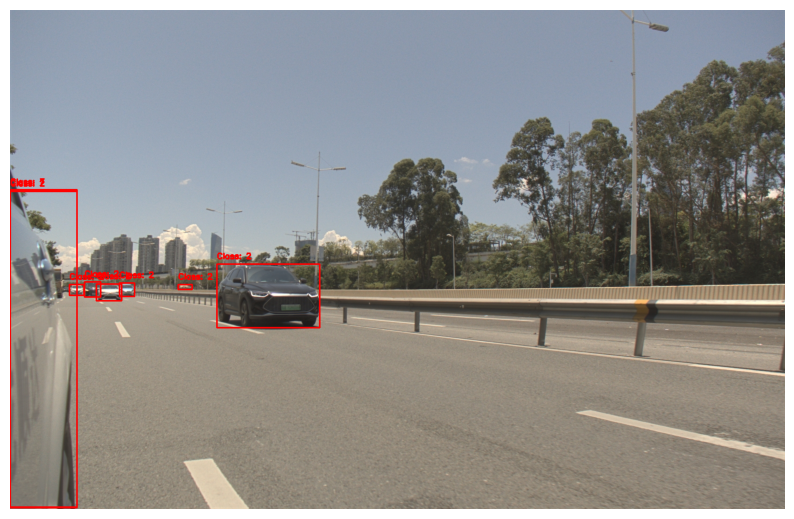

In [12]:
import torch
import cv2
from ultralytics.models import RTDETR
import matplotlib.pyplot as plt
import numpy as np

def load_image(image_path, device):
    """Load an image and normalize it to [0, 1] without resizing for plotting accuracy."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    original_shape = img.shape[:2]              # Store original (height, width)
    resized_img = cv2.resize(img, (640, 640))  # Resize to rtdetr input size
    resized_img = resized_img / 255.0           # Normalize to [0, 1]
    resized_img = torch.tensor(resized_img, dtype=torch.float32).permute(2, 0, 1)  # Shape: (C, H, W)
    resized_img = resized_img.unsqueeze(0).to(device)  # Add batch dimension
    return resized_img, img, original_shape


def inspect_rtdetr_with_real_image(weights_path, image_path, device):
    """Run rtdetr inference and return the result."""
    rtdetr_model = RTDETR(weights_path).to(device).eval()
    img_tensor, original_img, original_shape = load_image(image_path, device)

    with torch.no_grad():
        rtdetr_output = rtdetr_model(img_tensor)

        print('\n ===== rtdetr OUTPUT (REAL IMAGE) ====')
        result = rtdetr_output[0]

        print("\n--- Boxes ---")
        print(result.boxes.xyxy.cpu().numpy() if result.boxes else "No detections")

        print("\n--- Scores ---")
        print(result.boxes.conf.cpu().numpy() if result.boxes else "No scores")

        print("\n--- Labels ---")
        print(result.boxes.cls.cpu().numpy() if result.boxes else "No labels")

    return result, original_img, original_shape


def plot_image_with_boxes(original_img, result, original_shape):
    """Plot image with rtdetr bounding boxes and class labels, scaled to the original size."""
    img = original_img.copy()
    resized_shape = (640, 640)

    if result.boxes:
        # Scale bounding boxes from rtdetr size back to original image size
        boxes = result.boxes.xyxy.cpu().numpy()
        scale_w = original_shape[1] / resized_shape[0]
        scale_h = original_shape[0] / resized_shape[1]
        boxes[:, [0, 2]] *= scale_w
        boxes[:, [1, 3]] *= scale_h

        labels = result.boxes.cls.cpu().numpy()

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = map(int, box)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            img = cv2.putText(img, f'Class: {int(label)}', (x1, y1 - 10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# ========== RUN ==========
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rtdetr_weights_path = '/home/souval_g_WMGDS.WMG.WARWICK.AC.UK/Desktop/Multi-model-RAW-Network/rtdetr-l.pt'
image_path = '/home/souval_g_WMGDS.WMG.WARWICK.AC.UK/Desktop/Multi-model-RAW-Network/test_images/day-02078.jpg'

result, original_img, original_shape = inspect_rtdetr_with_real_image(rtdetr_weights_path, image_path, device)

# Plot image with bounding boxes
plot_image_with_boxes(original_img, result, original_shape)
